# Sarcasm Detection - Social media analytics

**CONTEXT**: Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.

**Dataset Description**: News Headlines dataset for Sarcasm Detection. The dataset is collected from two news websites, theonion.com and huffingtonpost.com. This new dataset has the following advantages over the existing Twitter datasets: Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embedding. Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets. Unlike tweets that reply to other tweets, the news headlines obtained are self- contained. This would help us in teasing apart the real sarcastic elements Content Each record consists of three attributes:

* is_sarcastic: 1 if the record is sarcastic otherwise 0
* headline: the headline of the news article
* article_link: link to the original news article. Useful in collecting supplementary data

**PROJECT OBJECTIVE**: Build a sequential NLP classifier which can use input text parameters to determine the customer sentiments.

## Import Libraries

In [4]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.style as style
import random
import re

import nltk 
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pratmish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pratmish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the data

In [6]:
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines = True)

## Shape of the data
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')

## Display the top 5 rows
data.head()

Data has 26709 rows and 3 columns. Here are the first five rows of the data...


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


### Exploratory Data Analysis

------------------------------------------------------------
Value Counts for `is_sarcastic` label
------------------------------------------------------------
Is Sarcastic count: 11724 i.e. 44.0%
Isn't Sarcastic count: 14985 i.e. 56.0%
------------------------------------------------------------
Distributon of `is_sarcastic` label
------------------------------------------------------------


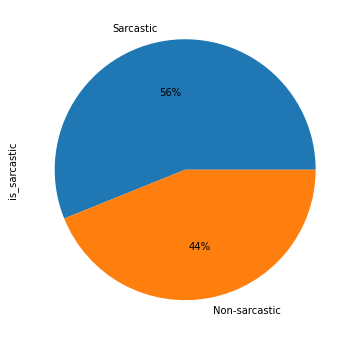

In [7]:
print('--'*30); print('Value Counts for `is_sarcastic` label'); print('--'*30)
print(f'Is Sarcastic count: {data[data.is_sarcastic == 1].shape[0]} i.e. {round(data[data.is_sarcastic == 1].shape[0]/data.shape[0]*100, 0)}%')
print(f'Isn\'t Sarcastic count: {data[data.is_sarcastic == 0].shape[0]} i.e. {round(data[data.is_sarcastic == 0].shape[0]/data.shape[0]*100, 0)}%')

print('--'*30); print('Distributon of `is_sarcastic` label'); print('--'*30)
_ = data['is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))

In [8]:
print('Analysis of `is_sarcastic` label by news website'); print('--'*30)

hf = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
op = data[data['article_link'].str.contains('theonion.com')].shape[0]

is_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 0)].shape[0]

is_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 0)].shape[0]

display(pd.DataFrame([[is_sarcastic_hf, is_sarcastic_op], [not_sarcastic_hf, not_sarcastic_op]], 
                     columns = ['huffingtonpost', 'theonion'], index = ['Sarcastic', 'Non-sarcastic']))

Analysis of `is_sarcastic` label by news website
------------------------------------------------------------


,huffingtonpost,theonion
Sarcastic,0,11724
Non-sarcastic,14985,1


In [9]:
# Checking 5 random headlines and labels from the data
print('--'*30); print('Checking 5 random headlines and labels from the data'); print('--'*30)
rands = random.sample(range(1, data.shape[0]), 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

------------------------------------------------------------
Checking 5 random headlines and labels from the data
------------------------------------------------------------
Headline: celebrities are freaking out as election results roll in
label: 0

Headline: federal judge pencils blocking trump's unconstitutional executive orders into monthly schedule
label: 1

Headline: résumé accidentally kept on file
label: 1

Headline: gaunt, hollow-eyed big bird enters sixth day of hunger strike against proposed trump budget
label: 1

Headline: clinton tosses unpledged superdelegate in trunk of car
label: 1



------------------------------------------------------------
Checking 5 random headlines and labels from the data where the length of headline is > 100
------------------------------------------------------------
Headline: 'new york times' moves all content you won't give a shit about unless you make at least $200k a year into one convenient section
label: 1

Headline: nutritious lunch brought from home broadcasts middle-aged coworker's recent health scare loud and clear
label: 1

Headline: report: majority of mothers would drop kids off at warehouse called 'fun zone' for hour of free time, no questions asked
label: 1

Headline: bound, gagged joaquin castro horrified by what his identical twin brother might be doing out on dnc floor
label: 1

Headline: nbc on olympics coverage: 'sorry we didn't alter the laws of space and time to accommodate people's schedules'
label: 1

------------------------------------------------------------
Distributon of label where the length of headline is > 

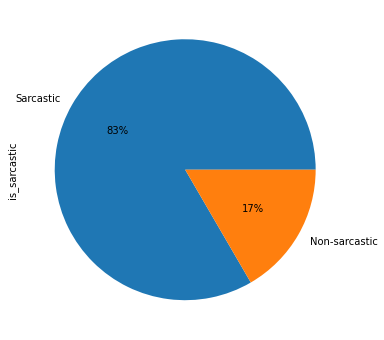

In [10]:
# Checking 5 random headlines and labels from the data where the length of headline is > 100
print('--'*30); print('Checking 5 random headlines and labels from the data where the length of headline is > 100'); print('--'*30)
indexes = list(data.loc[data['headline'].str.len() > 100, 'headline'].index)
rands = random.sample(indexes, 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

print('--'*30); print('Distributon of label where the length of headline is > 100'); print('--'*30)
_ = data.loc[indexes, 'is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))

### Observation

* 44% of the data have sarcastic labels whereas 56% don't.
* There are no headlines from HuffPost that are sarcastic whereas all but one from The Onion are sarcastic.
* Based on some random headlines seen above, it appears that the data is mostly lower-cased. Pre-processing such as removing punctuations and lemmatization can be used.
* There are digits in the headlines for e.g. 3 things i needed to hear when i weighed 300 pounds where removing the digits wouldn't help.
* 83% of data where length of sentence (headlines) > 100 are sarcastic headlines.

## Dropping irrelevant columns

Drop article_link from dataset

In [11]:
print('Dropping `article_link` from the data'); print('--'*30)
data.drop('article_link', axis = 1, inplace = True)

Dropping `article_link` from the data
------------------------------------------------------------


## Data Preprocessing
Few of the data pre-processing steps taken before applying model on the data

1. Converting to lower case, avoid any capital cases
2. Converting apostrophe to the standard lexicons
3. Removing punctuations
4. Lemmatization

In [12]:
nltk.download('averaged_perceptron_tagger')

appos = {"ain't": "am not", "aren't": "are not", "can't": "cannot", 
         "can't've": "cannot have", "'cause": "because", 
         "could've": "could have", "couldn't": "could not", 
         "couldn't've": "could not have", "didn't": "did not", 
         "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
         "hadn't've": "had not have", "hasn't": "has not", 
         "haven't": "have not", "he'd": "he would", "he'd've": "he would have", 
         "he'll": "he will", "he'll've": "he will have", 
         "he's": "he is", "how'd": "how did", 
         "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
         "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
         "I'll've": "I will have", "I'm": "I am", "I've": "I have", 
         "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
         "it'll": "it will", "it'll've": "it will have", "it's": "it is", 
         "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
         "might've": "might have", "mightn't": "might not", 
         "mightn't've": "might not have", "must've": "must have", 
         "mustn't": "must not", "mustn't've": "must not have", 
         "needn't": "need not", "needn't've": "need not have",
         "o'clock": "of the clock", "oughtn't": "ought not", 
         "oughtn't've": "ought not have", "shan't": "shall not", 
         "sha'n't": "shall not", "shan't've": "shall not have", 
         "she'd": "she would", "she'd've": "she would have", 
         "she'll": "she will", "she'll've": "she will have",
         "she's": "she is", "should've": "should have", 
         "shouldn't": "should not", "shouldn't've": "should not have", 
         "so've": "so have", "so's": "so is", 
         "that'd": "that had", "that'd've": "that would have", 
         "that's": "that that is", "there'd": "there would", 
         "there'd've": "there would have", "there's": "there is", 
         "they'd": "they would", "they'd've": "they would have", 
         "they'll": "they will", "they'll've": "they will have", 
         "they're": "they are", "they've": "they have", 
         "to've": "to have", "wasn't": "was not", "we'd": "we would", 
         "we'd've": "we would have", "we'll": "we will", 
         "we'll've": "we will have", "we're": "we are", 
         "we've": "we have", "weren't": "were not", 
         "what'll": "what will", "what'll've": "what will have", 
         "what're": "what are", "what's": "what is", 
         "what've": "what have", "when's": "when is", 
         "when've": "when have", "where'd": "where did", 
         "where's": "where is", "where've": "where have", 
         "who'll": "who will", "who'll've": "who will have", 
         "who's": "who is", "who've": "who have", 
         "why's": "why is", "why've": "why have", "will've": "will have", 
         "won't": "will not", "won't've": "will not have",
         "would've": "would have", "wouldn't": "would not", 
         "wouldn't've": "would not have", "y'all": "you all", 
         "y'all'd": "you all would", "y'all'd've": "you all would have", 
         "y'all're": "you all are", "y'all've": "you all have", 
         "you'd": "you would", "you'd've": "you would have",
         "you'll": "you will", "you'll've": "you will have", 
         "you're": "you are", "you've": "you have"}

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pratmish\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [13]:
# Helper function to replace appos
def replace_words(headline):
    cleaned_headlines = []
    for word in str(headline).split():
        if word.lower() in appos.keys():
            cleaned_headlines.append(appos[word.lower()])
        else:
            cleaned_headlines.append(word)
    return ' '.join(cleaned_headlines)

# Helper function to remove punctuations
PUNCT_TO_REMOVE = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' #string.punctuation
def remove_punctuation(text):
    """function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

# Helper function to lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    return ''.join([lemmatizer.lemmatize(word) for word in text])

# Helper function to remove stopwords
stoplist = set(stopwords.words('english'))
stoplist.remove('not')
def remove_stopwords(text):
    """function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in stoplist])

# Helper function for wordcloud
def plot_wordcloud(text, mask = None, max_words = 500, max_font_size = 40, 
                   figure_size = (12, 6), title = None, title_size = 15):
    wordcloud = WordCloud(background_color = 'white', max_words = max_words,
                          random_state = 42, width = 350, height = 150, 
                          mask = mask, stopwords = stoplist, collocations = False)
    wordcloud.generate(str(text))
    
    plt.figure(figsize = figure_size)
    plt.imshow(wordcloud, interpolation = 'bilinear');
    plt.title(title, fontdict = {'size': title_size, 'color': 'black', 
                               'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

# Second helper function for lemmatizing
lemmatizer = WordNetLemmatizer()
def lem(text):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(text.split())]))

In [14]:
print('--'*30)
print('Converting headlines to lower case')
data['cleaned_headline'] = data['headline'].apply(lambda x : x.lower())

print('Replacing apostrophes to the standard lexicons')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x : replace_words(x))

print('Removing punctuations')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_punctuation(x))

print('Applying Lemmatizer')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: lem(x))

print('Removing multiple spaces between words')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: re.sub(' +', ' ', x))

print('--'*30)

------------------------------------------------------------
Converting headlines to lower case
Replacing apostrophes to the standard lexicons
Removing punctuations
Applying Lemmatizer
Removing multiple spaces between words
------------------------------------------------------------


## Get the Length of each line and find the maximum length

As different lines are of different length. We need to pad the our sequences using the max length.

In [15]:
print('--'*40); print('Get the length of each line, find the maximum length and print the maximum length line'); 
print('Length of line ranges from 7 to 241.'); print('--'*40)
# Get length of each line
data['line_length'] = data['cleaned_headline'].str.len()

print('Minimum line length: {}'.format(data['line_length'].min()))
print('Maximum line length: {}'.format(data['line_length'].max()))
print('Line with maximum length: {}'.format(data[data['line_length'] == data['line_length'].max()]['cleaned_headline'].values[0]))

--------------------------------------------------------------------------------
Get the length of each line, find the maximum length and print the maximum length line
Length of line ranges from 7 to 241.
--------------------------------------------------------------------------------
Minimum line length: 7
Maximum line length: 241
Line with maximum length: maya angelou poet author civil right activist and—holy cow—tony award–nominated actress college professor magazine editor streetcar conductor—really streetcar conductor wow—calypso singer nightclub performer and foreign journalist dead at 86


In [16]:
print('--'*40); print('Get the number of words, find the maximum number of words and print the maximum number of words'); 
print('Number of words ranges from 2 to 39.'); print('--'*40)
# Get length of each line
data['nb_words'] = data['cleaned_headline'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(data['nb_words'].min()))
print('Maximum number of words: {}'.format(data['nb_words'].max()))
print('Line with maximum number of words: {}'.format(data[data['nb_words'] == data['nb_words'].max()]['cleaned_headline'].values[0]))

--------------------------------------------------------------------------------
Get the number of words, find the maximum number of words and print the maximum number of words
Number of words ranges from 2 to 39.
--------------------------------------------------------------------------------
Minimum number of words: 2
Maximum number of words: 39
Line with maximum number of words: elmore leonard modern prose master noted for his terse prose style and for writing about thing perfectly and succinctly with a remarkable economy of word unfortunately and sadly expired this gloomy tuesday at the age of 87 year old


## Modelling

In [17]:
print('--'*30); print('Five point summary for number of words')
display(data['nb_words'].describe().round(0).astype(int)); 

print('99% quantilie: {}'.format(data['nb_words'].quantile(0.99)));print('--'*30)

------------------------------------------------------------
Five point summary for number of words


count    26709
mean        10
std          3
min          2
25%          8
50%         10
75%         12
max         39
Name: nb_words, dtype: int32

99% quantilie: 18.0
------------------------------------------------------------


### Define parameters

In [18]:
max_features = 10000
maxlen = data['nb_words'].max()
embedding_size = 200

### Tokenization

In [19]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))

### Get X and y 

In [20]:
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print(f'Number of Samples: {len(X)}')
print(f'Number of Labels: {len(y)}')
print(f'\nFirst headline:\n{X[0]}\n\nLabel of the first headline: {y[0]}')

Number of Samples: 26709
Number of Labels: 26709

First headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  327  686 2924 1254   54  291  107 1915    6 2014 3610]

Label of the first headline: 0


### Get the Vocabulary size

In [21]:
# Reserve padding (indexed zero)
w2i = tokenizer.word_index
vocab_size = len(w2i) + 1
print(f'Number of unique tokens: {vocab_size}')

Number of unique tokens: 24962


### Word Embedding

#### Get Word Embeddings

In [24]:
EMBEDDING_FILE = 'glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE, encoding="utf8"):
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype = 'float32')
    embeddings[word] = embd

#### Create a weight matrix

In [25]:
# Getting the minimum number of words
num_words = min(max_features, vocab_size) + 1

embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

## Define and train the model

Steps/layers:

1. Split the data into train, valid and test set so that it's easy to compare and evaluate
2. Use Sequential model instance
3. Add Embedding layer
4. Bidirectional(LSTM) layer
5. GlobalMaxPool1D layer
6. Dense, dropout layers
7. Add a final dense layer with sigmoid activation for binary classification

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, shuffle = True)

print('---'*20, f'\nNumber of rows in training dataset: {X_train.shape[0]}')
print(f'Number of columns in training dataset: {X_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(X_train)))}')

print('---'*20, f'\nNumber of rows in test dataset: {X_test.shape[0]}')
print(f'Number of columns in test dataset: {X_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(X_test)))}')

------------------------------------------------------------ 
Number of rows in training dataset: 21367
Number of columns in training dataset: 39
Number of unique words in training dataset: 9953
------------------------------------------------------------ 
Number of rows in test dataset: 5342
Number of columns in test dataset: 39
Number of unique words in test dataset: 7330


In [28]:
## creating the model architecture
model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)  
mc = ModelCheckpoint('sarcasm_detector.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
lr_r = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5),
logdir = 'log'; tb = TensorBoard(logdir, histogram_freq = 1)
callbacks = [es, mc, lr_r, tb]

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 200)           2000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 39, 256)           336896    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [30]:
batch_size = 100
epochs = 6

history = model.fit(X_train, y_train, epochs = epochs, validation_split = 0.2, batch_size = batch_size, verbose = 2, callbacks = callbacks)

Epoch 1/6
171/171 - 32s - loss: 0.6020 - accuracy: 0.6635 - val_loss: 0.4620 - val_accuracy: 0.7815

Epoch 00001: val_loss improved from inf to 0.46201, saving model to sarcasm_detector.h5
Epoch 2/6
171/171 - 29s - loss: 0.4461 - accuracy: 0.8027 - val_loss: 0.3903 - val_accuracy: 0.8219

Epoch 00002: val_loss improved from 0.46201 to 0.39027, saving model to sarcasm_detector.h5
Epoch 3/6
171/171 - 27s - loss: 0.3788 - accuracy: 0.8393 - val_loss: 0.3644 - val_accuracy: 0.8400

Epoch 00003: val_loss improved from 0.39027 to 0.36441, saving model to sarcasm_detector.h5
Epoch 4/6
171/171 - 27s - loss: 0.3333 - accuracy: 0.8575 - val_loss: 0.3686 - val_accuracy: 0.8304

Epoch 00004: val_loss did not improve from 0.36441
Epoch 5/6
171/171 - 28s - loss: 0.3014 - accuracy: 0.8758 - val_loss: 0.3515 - val_accuracy: 0.8376

Epoch 00005: val_loss improved from 0.36441 to 0.35147, saving model to sarcasm_detector.h5
Epoch 6/6
171/171 - 28s - loss: 0.2737 - accuracy: 0.8908 - val_loss: 0.3417 - v

## Model Evaluation

In [31]:
loss, accuracy = model.evaluate(X_test, y_test, verbose = 0)
print('Overall Accuracy: {}'.format(round(accuracy * 100, 0)))

Overall Accuracy: 86.0


In [33]:
y_pred = (model.predict(X_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      2987
           1       0.84      0.83      0.84      2355

   micro avg       0.86      0.86      0.86      5342
   macro avg       0.85      0.85      0.85      5342
weighted avg       0.86      0.86      0.86      5342



------------------------------------------------------------
Confusion Matrix


,Non-sarcastic,Sarcastic
Non-sarcastic,2623,403
Sarcastic,364,1952


------------------------------------------------------------


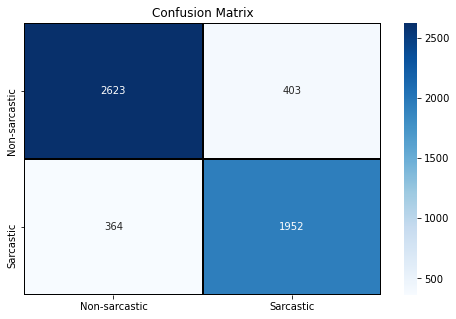

In [34]:
print('--'*30); print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['Non-sarcastic', 'Sarcastic'] , columns = ['Non-sarcastic','Sarcastic'])
display(cm); print('--'*30)

plt.figure(figsize = (8, 5))
_ = sns.heatmap(cm, cmap= 'Blues', linecolor = 'black' , linewidth = 1 , annot = True, 
            fmt = '' , xticklabels = ['Non-sarcastic', 'Sarcastic'], 
            yticklabels = ['Non-sarcastic', 'Sarcastic']).set_title('Confusion Matrix')

## Conclusion

* We used data pre-processing techniques to clean headlines, such as:
    * Converting to lower case
    * Converting to standard lexicons such as it's to it is
    * Remove punctuations
    * Lemmatize
    * Remove multiple spaces
* Some of the observation:
    * 44% of the data have sarcastic labels whereas 56% don't.
    * There are no headlines from HuffPost that are sarcastic whereas all but one from The Onion are sarcastic.
    * Based on some random headlines seen above, it appears that the data is mostly lower-cased. Pre-processing such as removing punctuations and lemmatization can be used.
    * There are digits in the headlines for e.g. 3 things i needed to hear when i weighed 300 pounds where removing the digits wouldn't help.
    * 83% of data where length of sentence (headlines) > 100 are sarcastic headlines.
* Used Glove embedding layer with Bidirectional LSTM layer. Model architecture was also plotted. Also saw how we can use tensorboard to visualize the metrics such as loss and accuracy.
* Created a separate training and test sets; while fitting the model kept aside a 0.2 for validation;
* Model achieved 86% accuracy on the test set; classification report and confusion matrix were also printed.
____________________________________